# Project

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/git/https%3A%2F%2Fgitlab.in2p3.fr%2Fenergy4climate%2Fpublic%2Feducation%2Fmachine_learning_for_climate_and_energy/master?filepath=book%2Fnotebooks%2Fprojects.ipynb)

<div class="alert alert-block alert-warning">
    <b>Schedule</b>
    
- Ask your supervisors for the data if not already provided (it is not included in this repository).
- Quick presentation.
- Final project presentation.
    
</div>

<div class="alert alert-block alert-info">
    <b>One problematic, One dataset, One (or more) method(s)</b>
    
- Quality of the dataset is key.
- Results on a clean notebook.
- Explain which method(s) you used and why.
- If a method fails, explain why.

</div>

## Project: Forecast of El Niño

<img alt="weather" src="images/ENSO-normal.png" width=400 style="float:left">
<img alt="weather" src="images/ENSO-El_Nino.png" width=400 style="float:right">

- Natural mode of variability of the pacific equatorial ocean
- Big impact on the local economy
- Question: What is the predictability of El Nino?

### Data set

<img alt="weather" src="images/monthly-sst-lanina-normal-elnino.png" width=400>

- Variable: Global sea surface temperature (SST)
- Temporal resolution: monthly mean
- Spatial resolution: 1 degree $\times$ 1 degree

### First steps

- Read about El nino
- Characterize El nino: i.e. introduce a classifier
- What does it mean ``to make a prediction''?

# Imports

In [1]:
import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.dates as mdates

import statsmodels.api as sm

from eofs.xarray import Eof

from pathlib import Path

# Functions

In [2]:
def plot_modes_regions(eof, modes=[0, 1]):

    # Niño 1+2 region (80°W–90°W → 270–280°E)
    n12_lon_min, n12_lon_max = 270, 280
    n12_lat_min, n12_lat_max = -10, 0

    # Niño 3 region (150°W–90°W → 210–270°E)
    n3_lon_min, n3_lon_max = 210, 270
    n3_lat_min, n3_lat_max = -5, 5

    # Niño 3.4 region (170°W–120°W → 190–240°E)
    n34_lon_min, n34_lon_max = 190, 240
    n34_lat_min, n34_lat_max = -5, 5

    color_n3  = 'blue'
    color_n34 = 'black'
    color_n12 = 'black'  

    for mode in modes:
        eof_field = eof[mode]

        fig, ax = plt.subplots(figsize=(16,4))
        eof_field.plot(ax=ax, cmap='RdBu_r')

        rect_n3 = patches.Rectangle(
            (n3_lon_min, n3_lat_min),
            n3_lon_max - n3_lon_min,
            n3_lat_max - n3_lat_min,
            linewidth=2,
            edgecolor=color_n3,
            facecolor='none'
        )
        ax.add_patch(rect_n3)
        ax.text(n3_lon_max - 12, n3_lat_max + 1, "Niño 3", color=color_n3)

        rect_n34 = patches.Rectangle(
            (n34_lon_min, n34_lat_min),
            n34_lon_max - n34_lon_min,
            n34_lat_max - n34_lat_min,
            linewidth=2,
            edgecolor=color_n34,
            facecolor='none'
        )
        ax.add_patch(rect_n34)
        ax.text(n34_lon_min, n34_lat_max + 1, "Niño 3.4", color=color_n34)

        rect_n12 = patches.Rectangle(
            (n12_lon_min, n12_lat_min),
            n12_lon_max - n12_lon_min,
            n12_lat_max - n12_lat_min,
            linewidth=2,
            edgecolor=color_n12,
            facecolor='none'
        )
        ax.add_patch(rect_n12)
        ax.text(n12_lon_min + 1, n12_lat_max + 1, "Niño 1+2", color=color_n12)

        ax.set_title(f"EOF{mode+1}: Mode {mode+1} of Tropical Pacific SST Variability")
        plt.show()

In [3]:
def plot_pricipal_components():

    pc1 = pc[:, 0]
    pc2 = pc[:, 1]
    
    time = pc['time'].values
    
    fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)
    
    axes[0].plot(time, pc1, color='red', label="PC1 (EOF1)")
    axes[0].axhline(0, color='black', linewidth=1)
    axes[0].set_ylabel("PC1 Amplitude")
    axes[0].set_title("Principal Components (PC1 and PC2)")
    axes[0].legend()
    
    axes[1].plot(time, pc2, color='blue', label="PC2 (EOF2)")
    axes[1].axhline(0, color='black', linewidth=1)
    axes[1].set_ylabel("PC2 Amplitude")
    axes[1].legend()
    
    axes[1].xaxis.set_major_locator(mdates.YearLocator(3))
    axes[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    axes[1].set_xlabel("Year")
    
    plt.tight_layout()
    plt.show()

In [4]:
def find_events(mask, min_length=6):
    """Return list of (start_date, end_date) tuples for events."""
    events = []
    in_event = False
    count = 0
    for i, val in enumerate(mask):
        if val and not in_event:
            start = mask.index[i]
            in_event = True
            count = 1
        elif val and in_event:
            count += 1
        elif not val and in_event:
            if count >= min_length:
                end = mask.index[i-1]
                events.append((start, end))
            in_event = False
 
    if in_event and count >= min_length:
        events.append((start, mask.index[-1]))
    return events

In [5]:
def plot_acf(df, nlags, region): 
    acf_vals, confint = sm.tsa.acf(df['monthly_anom'], nlags=nlags,alpha=0.05)
    
    lags = np.arange(len(acf_vals))
    
    
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.stem(lags, acf_vals, basefmt=" ")
    
    # Confidence interval
    ax.fill_between(
        lags,
        confint[:,0] - acf_vals,
        confint[:,1] - acf_vals,
        color='lightgray',
        alpha=0.5,
        label='95% confidence interval'
    )
    
    ax.set_title(f"Autocorrelation of {region} Monthly SST Anomalies")
    ax.set_xlabel("Lag (months)")
    ax.set_ylabel("Autocorrelation")
    
    ax.axhline(0, color='black', linewidth=1)
    ax.set_xlim(0, nlags)
    
    plt.show()

# Data

## Sea Surface Temperature (SST)

In [6]:
dir0 = Path('data')
file_sst = 'sst.mnmean.nc'

ds_sst = xr.open_dataset(Path(dir0, file_sst))
sst = ds_sst["sst"]

In [7]:
ds_sst

<xarray.Dataset> Size: 123MB
Dimensions:    (time: 475, lat: 180, lon: 360, nbnds: 2)
Coordinates:
  * time       (time) datetime64[ns] 4kB 1981-12-01 1982-01-01 ... 2021-06-01
  * lat        (lat) float32 720B 89.5 88.5 87.5 86.5 ... -87.5 -88.5 -89.5
  * lon        (lon) float32 1kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
Dimensions without coordinates: nbnds
Data variables:
    sst        (time, lat, lon) float32 123MB ...
    time_bnds  (time, nbnds) datetime64[ns] 8kB ...
Attributes:
    title:          NOAA Optimum Interpolation (OI) SST V2
    Conventions:    CF-1.0
    history:        Wed Apr  6 13:47:45 2005: ncks -d time,0,278 SAVEs/sst.mn...
    comments:       Data described in  Reynolds, R.W., N.A. Rayner, T.M.\nSmi...
    platform:       Model
    source:         NCEP Climate Modeling Branch
    institution:    National Centers for Environmental Prediction
    References:     https://www.psl.noaa.gov/data/gridded/data.noaa.oisst.v2....
    dataset_title:  NOAA Optimum Interpolation (OI) SST V2
    source_url:     http://www.emc.ncep.noaa.gov/research/cmb/sst_analysis/

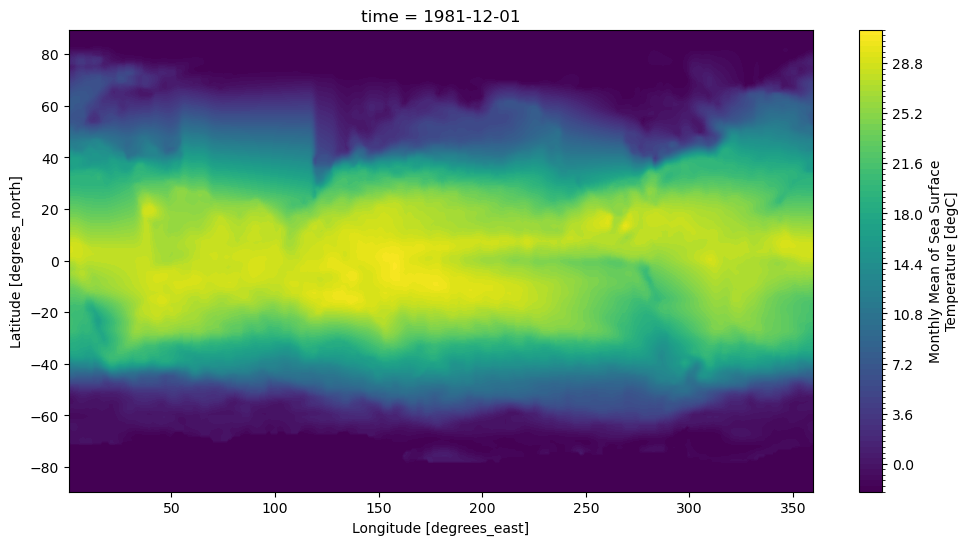

In [8]:
fig, ax = plt.subplots(figsize=(12, 6))
p = sst.isel(time=0).plot.contourf(ax=ax, levels=100, center=False)

## Mean Sea Level Pressure (MSLP)

In [9]:
file_mslp = 'mslp_coarse.nc'

ds_mslp = xr.open_dataset(Path(dir0, file_mslp))
mslp = ds_mslp['msl']

In [10]:
ds_mslp

<xarray.Dataset> Size: 138MB
Dimensions:    (time: 531, latitude: 181, longitude: 360)
Coordinates:
  * time       (time) datetime64[ns] 4kB 1979-01-01 1979-02-01 ... 2023-03-01
  * latitude   (latitude) float32 724B 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
  * longitude  (longitude) float32 1kB 0.0 1.0 2.0 3.0 ... 357.0 358.0 359.0
Data variables:
    msl        (time, latitude, longitude) float32 138MB ...
Attributes:
    Conventions:                 CF-1.6
    NCO:                         netCDF Operators version 4.9.1 (Homepage = h...
    title:                       ERA5 reanalysis
    data_type:                   1xmonthly fields analysis
    grid_resolution_in_degrees:  0.25
    source:                      credit: ECMWF, COPERNICUS Climate Change Ser...
    history:                     Thu Nov 30 14:28:43 2023: ncks -d longitude,...

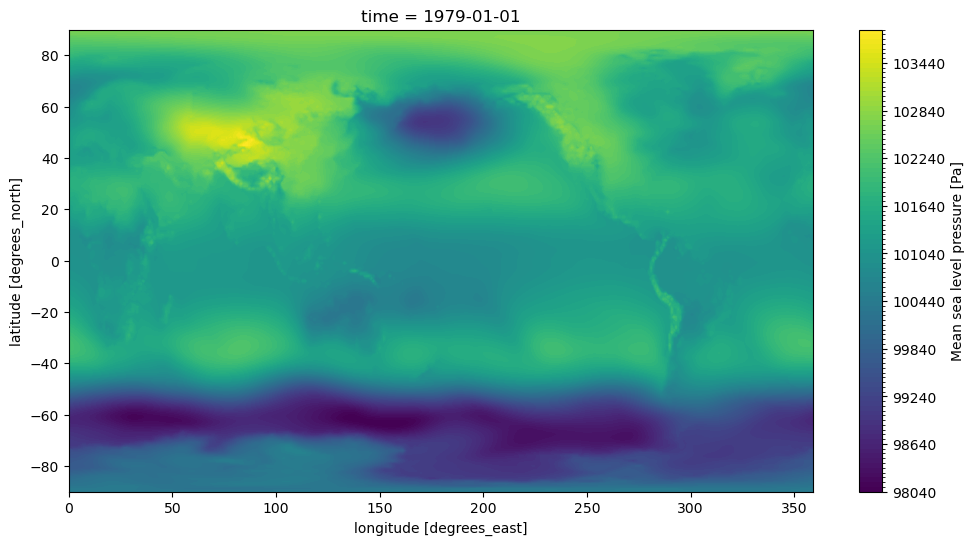

In [11]:
fig, ax = plt.subplots(figsize=(12, 6))
p = mslp.isel(time=0).plot.contourf(ax=ax, levels=100, center=False)

# EOF/PC (Empirical Orthogonal Function/Principal Component)

The SST anomaly map can be expressed as a weighted combination of a few dominant spatial patterns:

$$
\mathrm{SST}(x, y, t) = \sum_{k} \mathrm{PC}_k(t) \cdot \mathrm{EOF}_k(x, y)
$$

* $\mathrm{EOF}_k(x, y)$ are the spatial patterns (static map)
* $\mathrm{PC}_k(t)$ are the time series associated with each pattern.

With this, we will be able to reduce the huge dataset into a few meaningful modes.

We select the Tropical Pacific region to be analysed as 20°N-20°S, 120°E-80°W:

<center><img alt="weather" src="images/tropical-pacific.png" width=600></center>

In [12]:
# Monthly anomaly
clim = ds_sst.sel(time=slice('1981-01','2010-12')).groupby('time.month').mean('time')

# SST anomalies
sst_anom = ds_sst.groupby('time.month') - clim

# Tropical Pacific
sst_anom_tp = sst_anom.sel(lat=slice(20, -20), lon=slice(120, 280))

In [13]:
solver = Eof(sst_anom_tp['sst'])

# spatial pattern 
eof = solver.eofs(neofs=5)

# time series (PC)
pc  = solver.pcs(npcs=5)  

# variance explained
var = solver.varianceFraction()

## Variance Explained
To understand which modes are most relevant, we first examine the fraction of total SST-anomaly variance captured by each EOF. The variance explained plot highlights the dominance of the first modes.

The first 2 EOF Modes explain 58.266% of the variance.
The first 10 EOF Modes explain 81.496% of the variance.


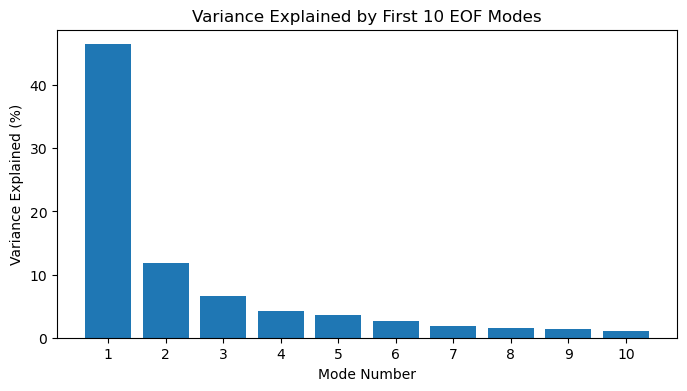

In [14]:
n_modes = min(10, len(var))
var10 = var[:n_modes] * 100 

print(f'The first 2 EOF Modes explain {np.sum(var10[:2]).item():.3f}% of the variance.')
print(f'The first 10 EOF Modes explain {np.sum(var10).item():.3f}% of the variance.')

fig, ax = plt.subplots(figsize=(8,4))

ax.bar(range(1, n_modes+1), var10)

ax.set_title("Variance Explained by First 10 EOF Modes")
ax.set_xlabel("Mode Number")
ax.set_ylabel("Variance Explained (%)")

ax.set_xticks(range(1, n_modes+1))

plt.show()

## Dominant modes of SST variability (EOF1 and EOF2)

The first two EOF modes together explain nearly 60% of the total variance in Tropical Pacific SST anomalies. 

* **EOF1** accounts for almost 50% of the variability and captures the classic ENSO pattern, with strong loadings across all Niño regions (1+2, 3, 3.4, and 4).
* **EOF2** explains about 11% of the variability and emphasizes changes in the Niño 1+2 area.

Higher order modes contribute less to the total variance and are not considered further here.

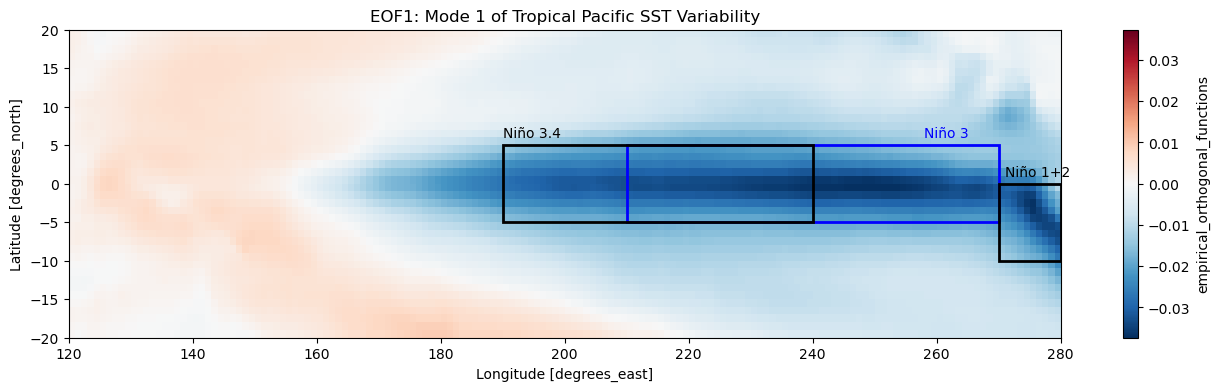

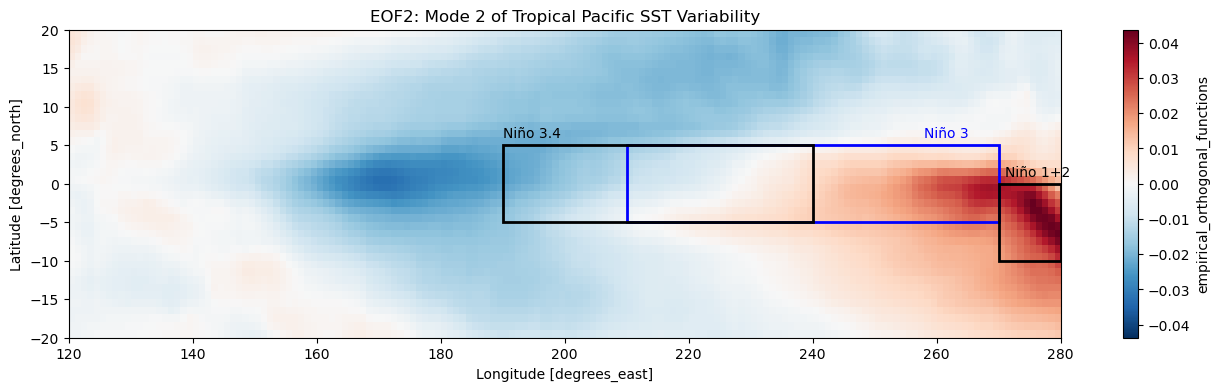

In [15]:
plot_modes_regions(eof, modes=[0, 1])

## Principal Components
The principal components describe how strongly each EOF mode is expressed over time. Plotting PC1 and PC2 allows us to see when the dominant SST variability patterns are active, highlighting periods associated with different types of ENSO behaviour.

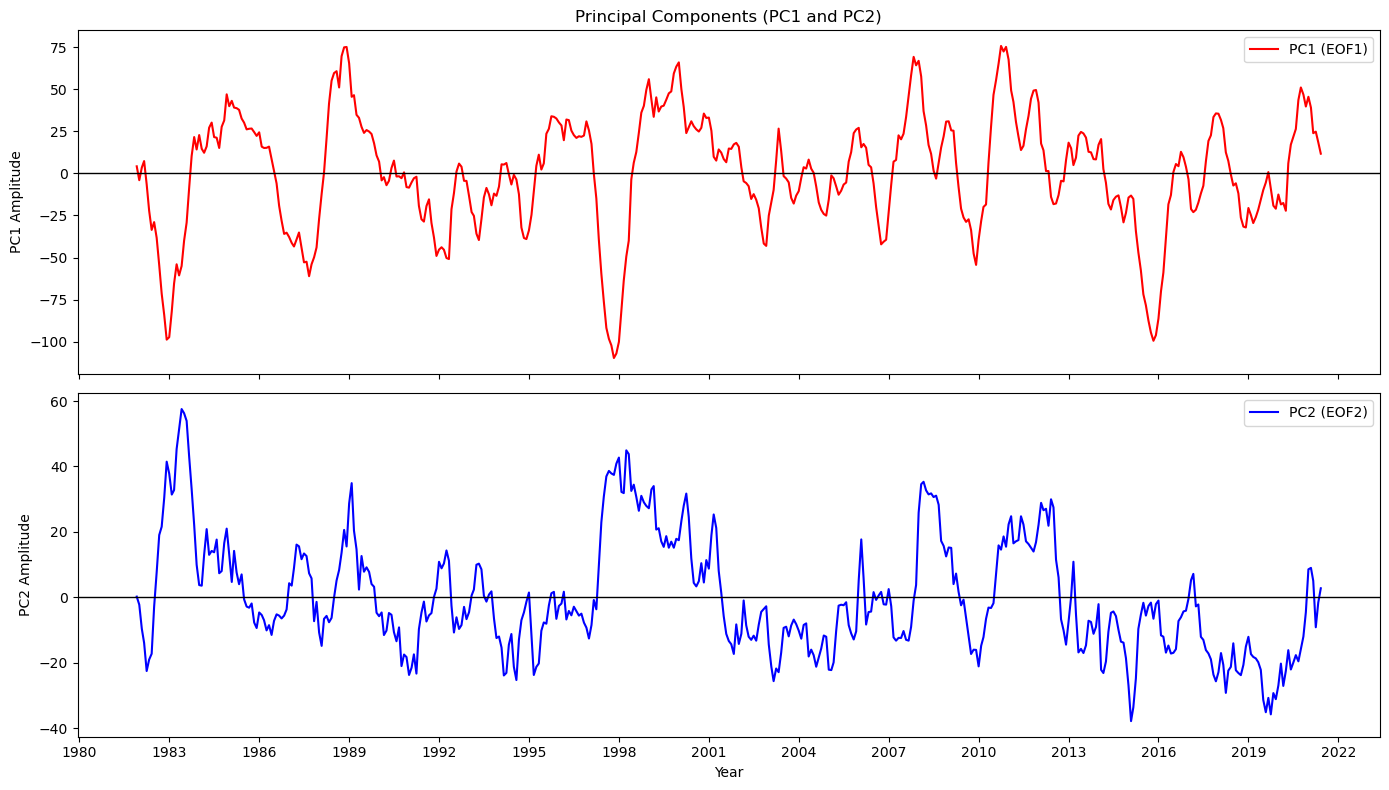

In [16]:
plot_pricipal_components()

### Orthogonality (PC1 and PC2)
Because EOF modes are constructed to be uncorrelated in time, PC1 and PC2 should be orthogonal. The scatterplot and correlation value below confirm this property, showing that the two time series are statistically independent despite their spatial patterns overlapping.

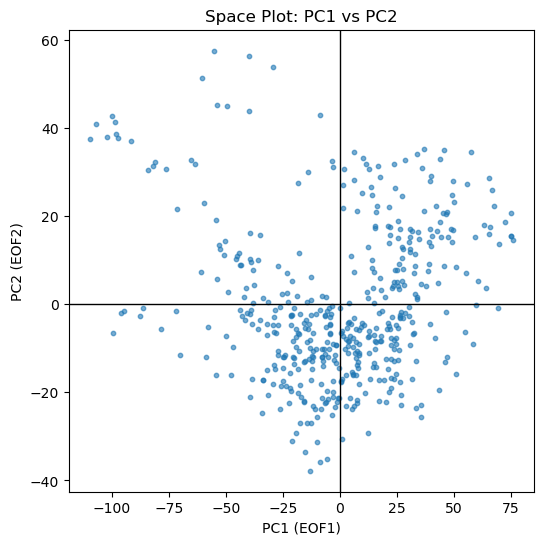

In [17]:
fig, ax = plt.subplots(figsize=(6,6))

ax.scatter(pc[:,0], pc[:,1], s=10, alpha=0.6)
ax.axhline(0, color='black', linewidth=1)
ax.axvline(0, color='black', linewidth=1)

ax.set_xlabel("PC1 (EOF1)")
ax.set_ylabel("PC2 (EOF2)")
ax.set_title("Space Plot: PC1 vs PC2")

plt.show()

In [18]:
correlation = np.round(np.corrcoef(pc[:,0], pc[:,1])[0,1],8)
print(f'Correlation between PC1 and PC2: {correlation}')

Correlation between PC1 and PC2: -0.0


# Characterizing El niño

In red: Niño 3 region (5°N-5°S, 90°-150°W)

In blue: Niño 3.4 region (5°N–5°S, 120°–170°W)

<center><img alt="weather" src="images/nino3-nino34.png" width=600></center>

* **Definition:** According to the National Center for Atmospheric Research (NCAR), an El Niño event occurs when the 5-month running mean of sea surface temperature (SST) anomalies in the Niño 3.4 region (5° N-5° S, 120°-170° W) remains above +0.4 °C for at least six consecutive months.

Given that we have nearly 40 years of data (from December 1981 to June 2021), we will use the first 30 years as the base period climatology, that is, the set of average temperatures for each of the 12 calendar months. Using this baseline, we will then compute SST anomalies for the entire time span.

1. Calculate monthly SST anomalies averaged for the areas known as "Niño 3" and "Niño 3.4".
2. Find periods during which 5-month running means of the monthly SST anomalies in the above mentioned areas are +0.5°C (Niño 3), +0.4°C (Niño 3.4) or more for at least six consecutive months.

In [19]:
nino_3   = dict(lat=slice(5, -5), lon=slice(210, 270))   # Niño 3 (150°W–90°W)
nino_34  = dict(lat=slice(5, -5), lon=slice(190, 240))   # Niño 3.4 (170°W–120°W)

sst_nino_3  = sst.sel(**nino_3).mean(dim=["lat", "lon"])
sst_nino_34 = sst.sel(**nino_34).mean(dim=["lat", "lon"])

In [20]:
nino_3_30y = sst_nino_3.sel(time=slice("1981-12", "2011-12"))
climatology_3 = nino_3_30y.groupby("time.month").mean("time")
nino_3_anom = sst_nino_3.groupby("time.month") - climatology_3

nino_34_30y = sst_nino_34.sel(time=slice("1981-12", "2011-12"))
climatology_34 = nino_34_30y.groupby("time.month").mean("time")
nino_34_anom = sst_nino_34.groupby("time.month") - climatology_34

## El Niño 3

### Monthly average SST

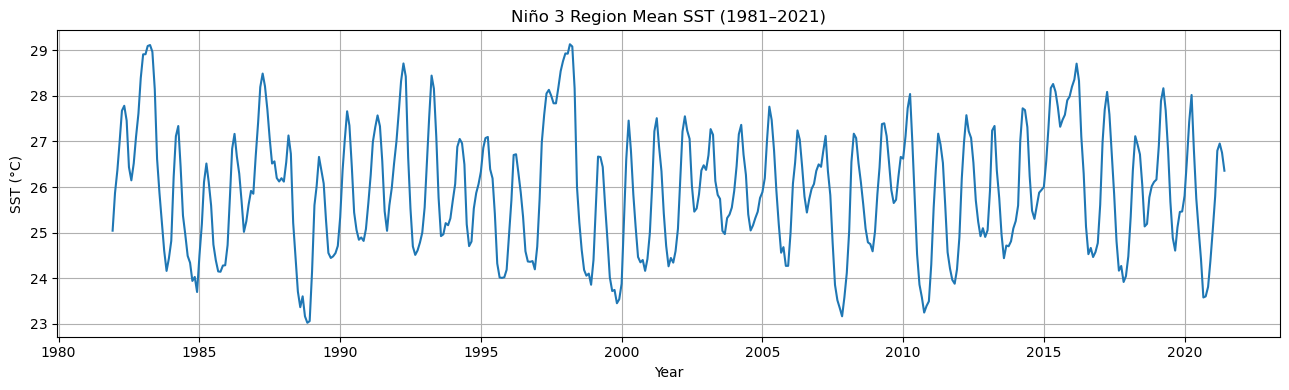

In [21]:
plt.figure(figsize=(13, 4))
plt.plot(sst_nino_3['time'], sst_nino_3)
plt.grid(True)

plt.gca().xaxis.set_major_locator(mdates.YearLocator(5))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.title('Niño 3 Region Mean SST (1981–2021)')
plt.xlabel('Year')
plt.ylabel('SST (°C)')
plt.tight_layout()
plt.show()

### Linear regression

Here, we numerically verify that there is no linear trend in the sea surface temperature time series for the Niño 3 region.

To do this, we run a simple linear regression:

$$
SST(t) = \beta_0 + \beta_1 t + \epsilon
$$

Then, we analyse the slope $\beta_1$:

- The trend estimate $\beta = -0.0015$ °C/year is almost zero.
- The p-value $p = 0.778$ is extremely not significant.
- The confidence interval $[-0.012\quad0.009]$ includes zero.
- The coefficient of determination $R^2 = 0.000$ shows the model explains basically none of the variance in the data.

With this, we conclude that the data behaves like an ENSO-dominated time series, without a long-term trend.

In [22]:
years = sst_nino_3['time'].dt.year + (sst_nino_3['time'].dt.month - 1)/12
y = sst_nino_3.values
X = sm.add_constant(years)

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                   0.07922
Date:                Thu, 11 Dec 2025   Prob (F-statistic):              0.778
Time:                        00:18:29   Log-Likelihood:                -814.88
No. Observations:                 475   AIC:                             1634.
Df Residuals:                     473   BIC:                             1642.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         28.9828     10.836      2.675      0.0

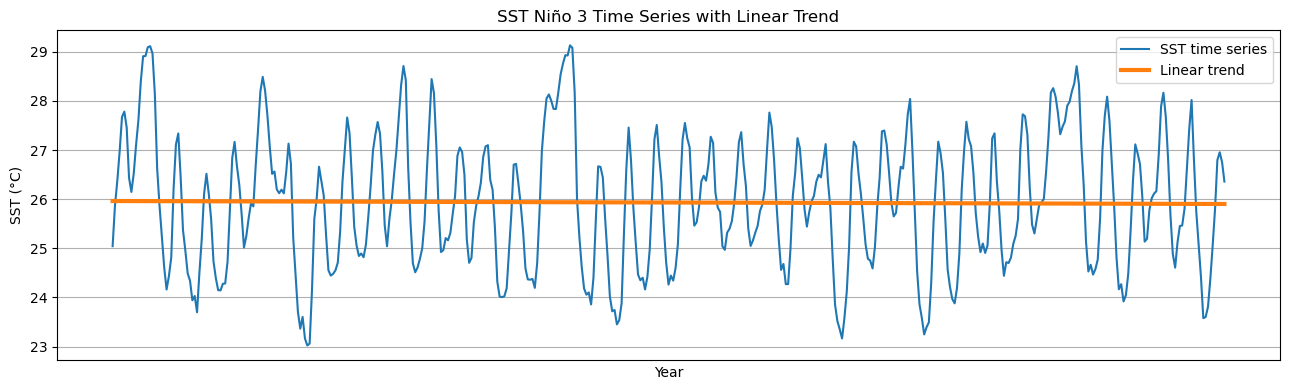

In [23]:
y_pred = model.predict(X)

plt.figure(figsize=(13, 4))
plt.plot(years, y, label='SST time series')
plt.plot(years, y_pred, label='Linear trend', linewidth=3)
plt.grid(True)

plt.gca().xaxis.set_major_locator(mdates.YearLocator(5))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.title('SST Niño 3 Time Series with Linear Trend')
plt.xlabel('Year')
plt.ylabel('SST (°C)')
plt.legend()
plt.tight_layout()
plt.show()

### SST Anomalies

In [24]:
nino_3_5mo = nino_3_anom.rolling(time=5, center=True).mean()
anom = nino_3_5mo.to_series()

# El Niño and La Niña conditions
is_elnino = anom > 0.5
is_lanina = anom < -0.5

elnino_periods_nino3 = find_events(is_elnino)
lanina_periods_nino3 = find_events(is_lanina)

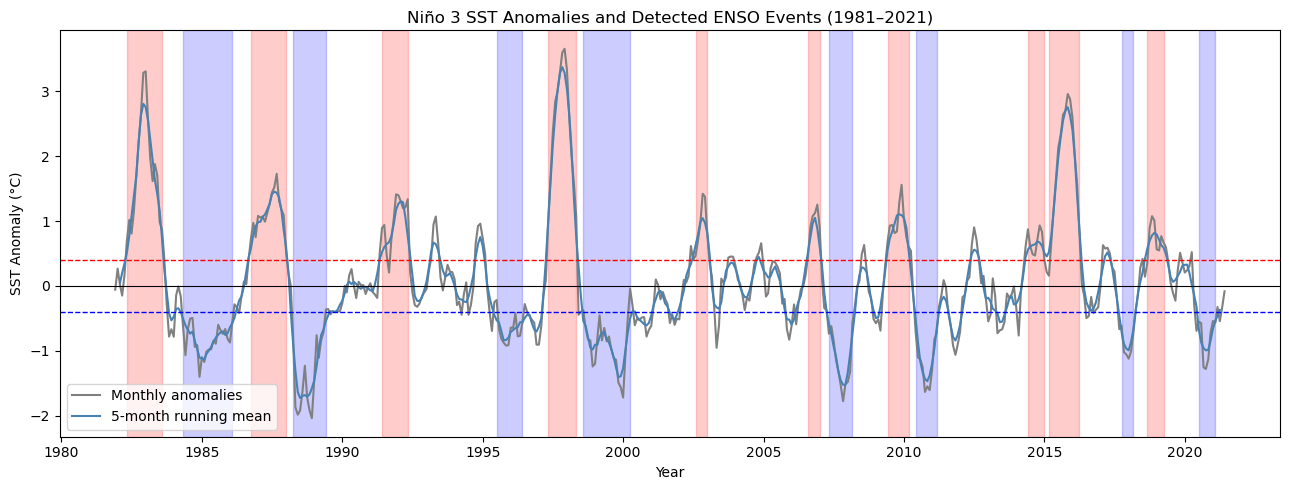

In [25]:
plt.figure(figsize=(13,5))
plt.plot(anom.index, nino_3_anom, color='gray', label='Monthly anomalies')
plt.plot(anom.index, anom, color='steelblue', label='5-month running mean')

plt.axhline(0.4, color='red', linestyle='--', linewidth=1)
plt.axhline(-0.4, color='blue', linestyle='--', linewidth=1)
plt.axhline(0, color='black', linewidth=0.8)

# Shade El Niño and La Niña events
for start, end in elnino_periods_nino3:
    plt.axvspan(start, end, color='red', alpha=0.2)
for start, end in lanina_periods_nino3:
    plt.axvspan(start, end, color='blue', alpha=0.2)

plt.gca().xaxis.set_major_locator(mdates.YearLocator(5))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.title('Niño 3 SST Anomalies and Detected ENSO Events (1981–2021)')
plt.xlabel('Year')
plt.ylabel('SST Anomaly (°C)')
plt.legend()
plt.tight_layout()
plt.show()

We define a dataframe with flags that refer to the phase of each month, classified from the analysis of the Niño 3 region:

| Flag | ENSO Phase |
| :- | -: |
| **2** | El Niño |
| **1** | La Niña |
| **0** | Neither |

In [26]:
df_nino3 = pd.DataFrame({
    'timestamp': anom.index,
    'mean_SST': sst_nino_3,
    'monthly_anom': nino_3_anom,
    '5mo_running_anom': anom,
    'flag': 0, #placeholder
})

# flag el nino and la nina periods
for start, end in elnino_periods_nino3:
    df_nino3.loc[(df_nino3.index >= start) & (df_nino3.index <= end), "flag"] = 2
for start, end in lanina_periods_nino3:
    df_nino3.loc[(df_nino3.index >= start) & (df_nino3.index <= end), "flag"] = 1

df_nino3.head()

,timestamp,mean_SST,monthly_anom,5mo_running_anom,flag
time,,,,,
1981-12-01,1981-12-01,25.043583,-0.057739,NaN,0
1982-01-01,1982-01-01,25.868416,0.267349,NaN,0
1982-02-01,1982-02-01,26.374184,0.013205,0.050568,0
1982-03-01,1982-03-01,26.974382,-0.147888,0.201229,0
1982-04-01,1982-04-01,27.675814,0.177916,0.351203,0


## El Niño 3.4

### Monthly average SST

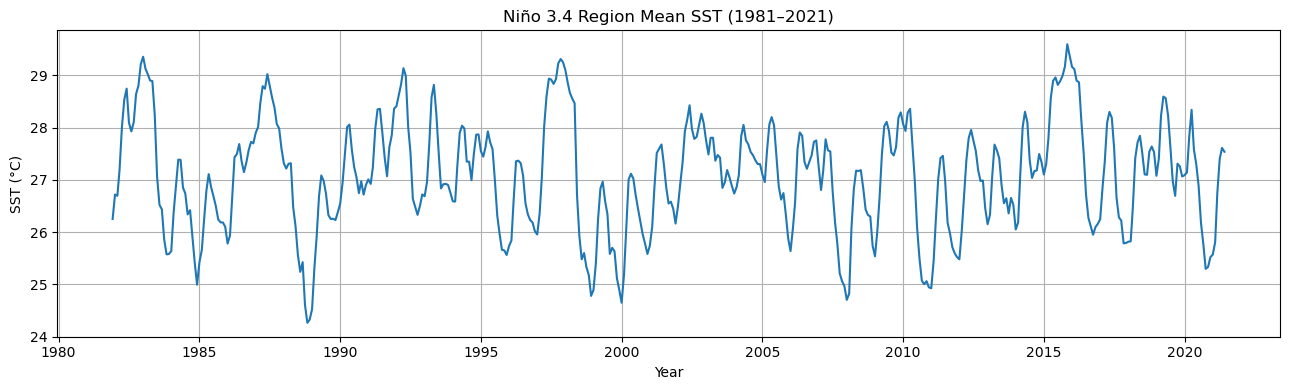

In [27]:
plt.figure(figsize=(13, 4))
plt.plot(sst_nino_34['time'], sst_nino_34)
plt.grid(True)

plt.gca().xaxis.set_major_locator(mdates.YearLocator(5))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.title('Niño 3.4 Region Mean SST (1981–2021)')
plt.xlabel('Year')
plt.ylabel('SST (°C)')
plt.tight_layout()
plt.show()

### Linear Regression

Here, we numerically verify that there is no linear trend in the sea surface temperature time series for the Niño 3.4 region.

To do this, we run a simple linear regression:

$$
SST(t) = \beta_0 + \beta_1 t + \epsilon
$$

Then, we analyse the slope $\beta_1$:

- The trend estimate $\beta = -0.0009$ °C/year is almost zero.
- The p-value $p = 0.826$ is extremely not significant.
- The confidence interval $[-0.009\quad0.007]$ includes zero.
- The coefficient of determination $R^2 = 0.000$ shows the model explains basically none of the variance in the data.

With this, we conclude that the data for this region also behaves like an ENSO-dominated time series, without a long-term trend.

In [28]:
years = sst_nino_34['time'].dt.year + (sst_nino_34['time'].dt.month - 1)/12
y = sst_nino_34.values
X = sm.add_constant(years)

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                   0.04819
Date:                Thu, 11 Dec 2025   Prob (F-statistic):              0.826
Time:                        00:18:30   Log-Likelihood:                -701.57
No. Observations:                 475   AIC:                             1407.
Df Residuals:                     473   BIC:                             1415.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         28.9467      8.536      3.391      0.0

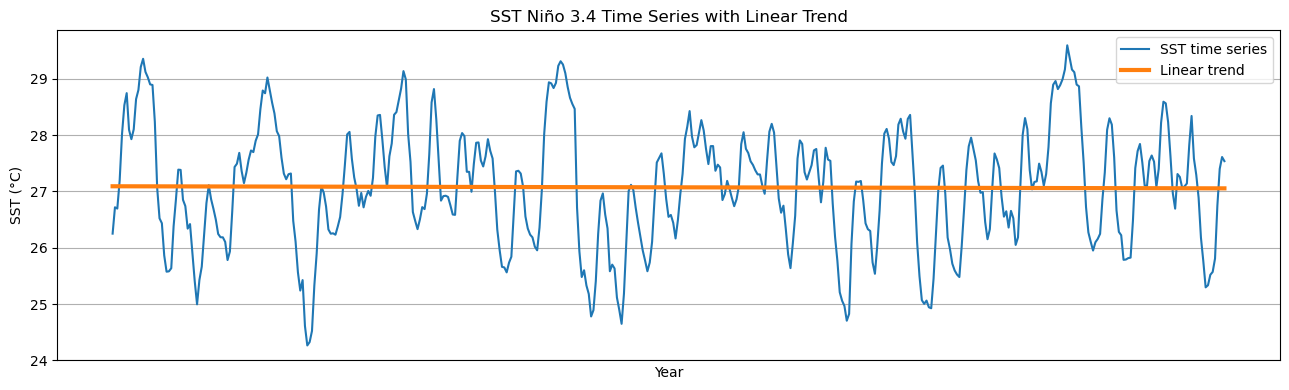

In [29]:
y_pred = model.predict(X)

plt.figure(figsize=(13, 4))
plt.plot(years, y, label='SST time series')
plt.plot(years, y_pred, label='Linear trend', linewidth=3)
plt.grid(True)

plt.gca().xaxis.set_major_locator(mdates.YearLocator(5))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.title('SST Niño 3.4 Time Series with Linear Trend')
plt.xlabel('Year')
plt.ylabel('SST (°C)')
plt.legend()
plt.tight_layout()
plt.show()

### SST Anomalies

In [30]:
nino_34_5mo = nino_34_anom.rolling(time=5, center=True).mean()
anom = nino_34_5mo.to_series()

# El Niño and La Niña conditions
is_elnino = anom > 0.4
is_lanina = anom < -0.4

elnino_periods_nino34 = find_events(is_elnino)
lanina_periods_nino34 = find_events(is_lanina)

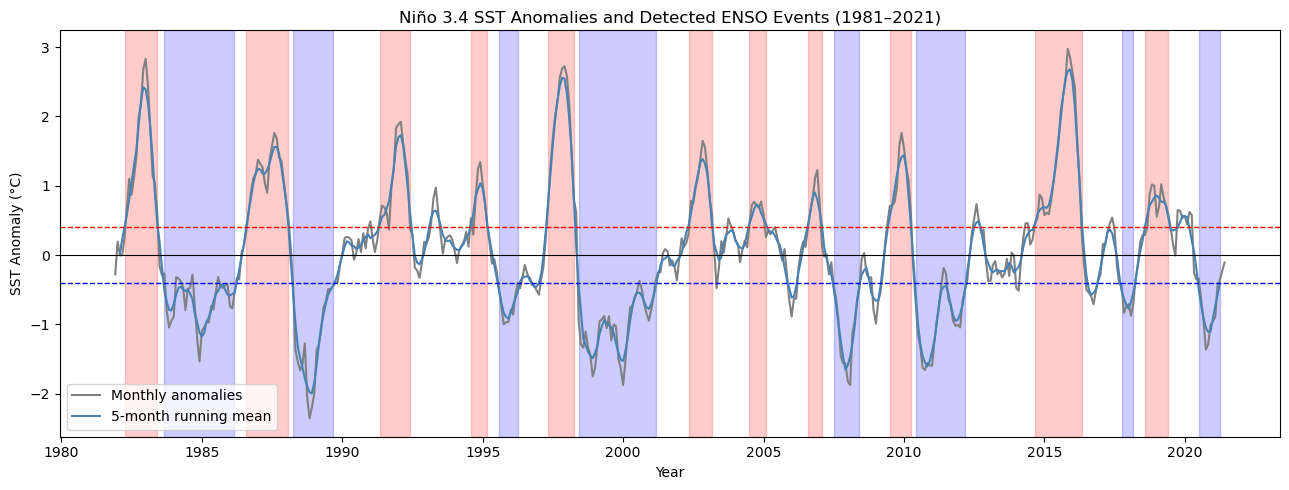

In [31]:
plt.figure(figsize=(13,5))
plt.plot(anom.index, nino_34_anom, color='gray', label='Monthly anomalies')
plt.plot(anom.index, anom, color='steelblue', label='5-month running mean')

plt.axhline(0.4, color='red', linestyle='--', linewidth=1)
plt.axhline(-0.4, color='blue', linestyle='--', linewidth=1)
plt.axhline(0, color='black', linewidth=0.8)

# Shade El Niño and La Niña events
for start, end in elnino_periods_nino34:
    plt.axvspan(start, end, color='red', alpha=0.2)
for start, end in lanina_periods_nino34:
    plt.axvspan(start, end, color='blue', alpha=0.2)

plt.gca().xaxis.set_major_locator(mdates.YearLocator(5))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.title('Niño 3.4 SST Anomalies and Detected ENSO Events (1981–2021)')
plt.xlabel('Year')
plt.ylabel('SST Anomaly (°C)')
plt.legend()
plt.tight_layout()
plt.show()

We define a dataframe with flags that refer to the phase of each month, classified from the analysis of the Niño 3.4 region:

| Flag | ENSO Phase |
| :- | -: |
| **2** | El Niño |
| **1** | La Niña |
| **0** | Neither |

In [32]:
df_nino34 = pd.DataFrame({
    'timestamp': anom.index,
    'mean_SST': sst_nino_34,
    'monthly_anom': nino_34_anom,
    '5mo_running_anom': anom,
    'flag': 0, #placeholder
})

# flag el nino and la nina periods
for start, end in elnino_periods_nino34:
    df_nino34.loc[(df_nino34.index >= start) & (df_nino34.index <= end), "flag"] = 2
for start, end in lanina_periods_nino34:
    df_nino34.loc[(df_nino34.index >= start) & (df_nino34.index <= end), "flag"] = 1

## Southern Oscillation Index (SOI)

The Southern Oscillation Index (SOI) is a measure of the atmospheric part of ENSO — the pressure difference between the western and eastern tropical Pacific. It gives an indication of the development and intensity of El Niño or La Niña events in the Pacific Ocean. 

- Sustained negative values of the SOI lower than $−7$ (low pressure in the east) often indicate **El Niño** episodes.
- Sustained positive values of the SOI greater than $+7$ (low pressure in the west) are typical of a **La Niña** episode.

Here we use the Troup method for calculating the SOI, which takes the standardised anomaly of the Means Sea Level Pressure difference between Tahiti and Darwin stations. The multiplication by 10 is a convention which makes the SOI value be quoted as a whole number ranging from about –35 to about +35. We use the 30-year base period from 1981-2011. [3]

$$
SOI = 10 \frac{P_{\text{diff}} - P_{\text{diff}_{\text{av}}}}{\sigma_{P_{\text{diff}}}}
$$
where:

- $P_{\text{diff}} = \text{MSLP}_\text{Tahiti} - \text{MSLP}_\text{Darwin}$
- $P_{\text{diff}_{\text{av}}} = $ long term average of $P_{\text{diff}}$ for the month in question
- $ \sigma_{P_{\text{diff}}} = $ long term standard deviation of $P_{\text{diff}}$ for the month in question

<center><img alt="weather" src="images/darwin-tahiti.png" width=850></center>

In [33]:
# Extract grid cells near Tahiti and Darwin
tahiti = mslp.sel(latitude=-17.5, longitude=210, method='nearest')
darwin = mslp.sel(latitude=-12.5, longitude=131, method='nearest')

p_diff = tahiti - darwin

In [34]:
# get statistics from 30-year base period
p_diff_30y = p_diff.sel(time=slice("1981-12", "2011-12"))

p_diff_av = p_diff_30y.groupby("time.month").mean("time")
p_diff_std = p_diff_30y.groupby("time.month").std("time")

In [35]:
# compute SOI time series for the whole period
month_index = p_diff["time.month"]

soi = 10 * (
    (p_diff - p_diff_av.sel(month=month_index))
    / p_diff_std.sel(month=month_index)
)

In [36]:
# find anomalies
soi_3mo = soi.rolling(time=3, center=True).mean()

soi = soi.to_series()
soi_3mo = soi_3mo.to_series()

negative = soi_3mo < -7
positive = soi_3mo > 7

soi_neg_periods = find_events(negative) # indicate el nino
soi_pos_periods = find_events(positive) # indicate la nina

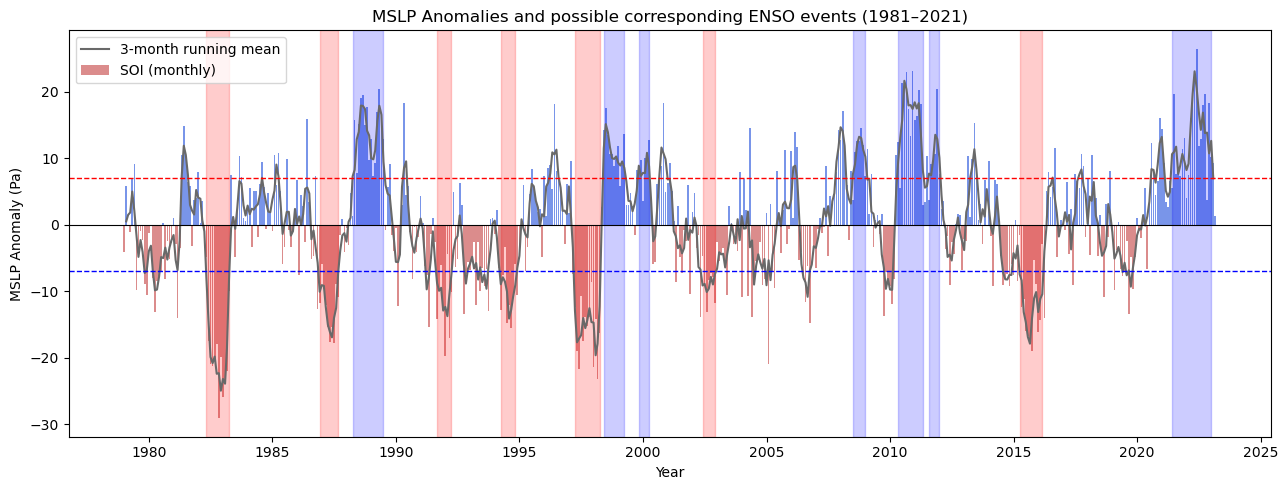

In [37]:
plt.figure(figsize=(13,5))

bar_colors = ['royalblue' if v >= 0 else 'indianred' for v in soi.values]

plt.bar(soi.index, soi.values, width=25, color=bar_colors, alpha=0.7, label='SOI (monthly)')

# plt.plot(soi.index, soi, color='gray', label='SOI', alpha=0.5)
plt.plot(soi.index, soi_3mo, color='dimgray', label='3-month running mean')

plt.axhline(7,  color='red',  linestyle='--', linewidth=1)
plt.axhline(-7, color='blue', linestyle='--', linewidth=1)
plt.axhline(0,  color='black', linewidth=0.8)

for start, end in soi_neg_periods:
    plt.axvspan(start, end, color='red', alpha=0.2)
for start, end in soi_pos_periods:
    plt.axvspan(start, end, color='blue', alpha=0.2)

plt.gca().xaxis.set_major_locator(mdates.YearLocator(5))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.title('MSLP Anomalies and possible corresponding ENSO events (1981–2021)')
plt.xlabel('Year')
plt.ylabel('MSLP Anomaly (Pa)')
plt.legend()
plt.tight_layout()
plt.show()


In [38]:
df_ninoSOI = pd.DataFrame({
    'timestamp': soi.index,
    'tahiti-darwin': p_diff,
    'soi': soi,
    '3mo_running_anom': soi_3mo,
    'flag': 0, #placeholder
})

# flag el nino and la nina periods
for start, end in soi_neg_periods:
    df_ninoSOI.loc[(df_ninoSOI.index >= start) & (df_ninoSOI.index <= end), "flag"] = 2
for start, end in soi_pos_periods:
    df_ninoSOI.loc[(df_ninoSOI.index >= start) & (df_ninoSOI.index <= end), "flag"] = 1

# df_ninoSOI.head()

# Exploratory Analysis

## Autocorrelation (ACF)

We compute the autocorrelation using the SST anomalies to remove the mean seasonal cycle and isolate ENSO variability. Both indices show a strong positive autocorrelation during the first 6 months, meaning the anomalies persist over this period. Around lag 9, the correlation drops to near zero, indicating a loss of memory. 

The grey shading represents the 95% confidence interval: values outside this region are statistically significant and not due to random noise. The significant negative correlations between lags 21–28 suggest an opposite-phase tendency, where warm anomalies are often followed by cooler anomalies about two years later.

### Niño 3

In [39]:
nlags = 36
plot_acf(df3, nlags, region='Niño 3')

NameError: name 'df3' is not defined

### Niño 3.4

In [ ]:
nlags = 36
plot_acf(df34, nlags, region='Niño 3.4')

## Lag correlation

### Global SST vs. Niño 3.4

In [ ]:
max_lag = 12
lag_corr = []

for lag in range(max_lag+1):
    n34_shifted = nino_34_anom.shift(time=-lag)
    corr = xr.corr(sst, n34_shifted, dim='time')
    lag_corr.append(corr)

In [ ]:
# Niño 3.4 bounds
lat_min, lat_max = -5, 5
lon_min, lon_max = 190, 240

for lag in range(13):
    
    fig, ax = plt.subplots(figsize=(12, 6))
    lag_corr[lag].plot(ax=ax, vmin=-1, vmax=1, cmap='RdBu_r')
    
    rect = patches.Rectangle((lon_min, lat_min),lon_max - lon_min,lat_max - lat_min,linewidth=2,edgecolor='black',facecolor='none')
    ax.add_patch(rect)
    
    ax.set_title(f"Lag {lag} SST vs Niño3.4 correlation")
    plt.show()

# References

[1] https://journals.ametsoc.org/view/journals/bams/78/12/1520-0477_1997_078_2771_tdoeno_2_0_co_2.pdf

[2] https://www.ncei.noaa.gov/access/monitoring/enso/soi

[3] https://www.bom.gov.au/climate/enso/soi/ 

[4] https://environment.govt.nz/assets/publications/Environmental-Reporting/Atmosphere-and-climate-indcators-2023-updated-datasets.pdf

Further references to explore:

- https://rmets.onlinelibrary.wiley.com/doi/epdf/10.1002/qj.49709139009
- https://www.longpaddock.qld.gov.au/soi/

# Things to explore

1) trend: (1) regressão linear, ver se o R^2 e coeff é relevante o suficiente (p-value) (2) decomposição ARIMA -> importante pra checar se a baseline é válida (n pode ter trend) -> o que fazer se tiver?

2) [Não necessariamente fazer, mas é uma sequencia] PCA em região específica para ver se tem outros index interessantes (se as regiões 3 e 3.4 são as mais explicativas)

3) [paralelo] flag de fenomenos e ver a sazonalidade deles (checar se é possivel)
- lag correlation (delayed oscillator) tanto entre as regiões quanto com a pressão
- flag de fenomenos e ver a sazonalidade deles (checar se é possivel)
- classificação: colocar flags de fenomeno (el nino, la nina, nada) no tempo e ver se tem classificações de SOI (intervalos de valores que sempre batem)

***
## Credit

[//]: # "This notebook is part of [E4C Interdisciplinary Center - Education](https://gitlab.in2p3.fr/energy4climate/public/education)."
Contributors include Bruno Deremble and Alexis Tantet.
Several slides and images are taken from the very good [Scikit-learn course](https://inria.github.io/scikit-learn-mooc/).

<br>

<div style="display: flex; height: 70px">
    
<img alt="Logo LMD" src="images/logos/logo_lmd.jpg" style="display: inline-block"/>

<img alt="Logo IPSL" src="images/logos/logo_ipsl.png" style="display: inline-block"/>

<img alt="Logo E4C" src="images/logos/logo_e4c_final.png" style="display: inline-block"/>

<img alt="Logo EP" src="images/logos/logo_ep.png" style="display: inline-block"/>

<img alt="Logo SU" src="images/logos/logo_su.png" style="display: inline-block"/>

<img alt="Logo ENS" src="images/logos/logo_ens.jpg" style="display: inline-block"/>

<img alt="Logo CNRS" src="images/logos/logo_cnrs.png" style="display: inline-block"/>
    
</div>

<hr>

<div style="display: flex">
    <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0; margin-right: 10px" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a>
    <br>This work is licensed under a &nbsp; <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.
</div>